In [175]:
import numpy as np 
import pandas as pd
import os


In [176]:
for dirname, _, filenames in os.walk(r"D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\.~lock.holidays_events.csv#
D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\.~lock.oil.csv#
D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\.~lock.sample_submission.csv#
D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\.~lock.stores.csv#
D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\.~lock.train.csv#
D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\.~lock.transactions.csv#
D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\holidays_events.csv
D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\oil.csv
D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\sample_submission.csv
D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\stores.csv
D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\test.csv
D:\IMARTICUS\Python\ML_E

In [177]:
train = pd.read_csv(r'D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\train.csv')
test = pd.read_csv(r'D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\test.csv')
sample_submission = pd.read_csv(r'D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\sample_submission.csv')
oil = pd.read_csv(r'D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\oil.csv')
stores = pd.read_csv(r'D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\stores.csv')
holiday = pd.read_csv(r'D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\holidays_events.csv')
transactions = pd.read_csv(r'D:\IMARTICUS\Python\ML_EXAM\WBeyond_Internship\store_forecasting_data\transactions.csv').sort_values(["store_nbr", "date"])

In [178]:
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)
holiday["date"] = pd.to_datetime(holiday.date)
oil["date"] = pd.to_datetime(oil.date)

In [179]:
train['onpromotion'] = train['onpromotion'].astype("float16")
test['onpromotion'] = test['onpromotion'].astype("float16")  # Ensuring consistent data type
train['sales'] = train['sales'].astype("float32")
stores['cluster'] = stores['cluster'].astype("int8")

In [180]:
def merge_with_lagged_features(df, oil, holidays):
    # Petrol fiyatlarını 7 gün gecikmeli ekle
    df = df.merge(oil.assign(date=oil['date'] + pd.DateOffset(days=7)), on='date', how='left', suffixes=('', '_lag_7'))
    # Tatil bilgilerini dinamik olarak birleştir
    df = df.merge(holidays, on='date', how='left')
    return df

train1 = merge_with_lagged_features(train, oil, holiday)
test = merge_with_lagged_features(test, oil, holiday)
train1 = train1.merge(stores, on='store_nbr', how='left')
train1 = train1.merge(transactions, on=['date', 'store_nbr'], how='left')
train1 = train1.rename(columns={"type_x": "holiday_type", "type_y": "store_type"})

In [181]:
train1['date'] = pd.to_datetime(train1['date'])
train1['year'] = train1['date'].dt.year
train1['month'] = train1['date'].dt.month
train1['week'] = train1['date'].dt.isocalendar().week
train1['quarter'] = train1['date'].dt.quarter
train1['day_of_week'] = train1['date'].dt.day_name()

In [182]:
train1.columns


Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'dcoilwtico', 'holiday_type', 'locale', 'locale_name', 'description',
       'transferred', 'city', 'state', 'store_type', 'cluster', 'transactions',
       'year', 'month', 'week', 'quarter', 'day_of_week'],
      dtype='object')

In [183]:
train1.describe()


C:\Users\kaush\anaconda3\envs\kaush\lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
C:\Users\kaush\anaconda3\envs\kaush\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\kaush\anaconda3\envs\kaush\lib\site-packages\pandas\core\nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
C:\Users\kaush\anaconda3\envs\kaush\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\kaush\anaconda3\envs\kaush\lib\site-packages\pandas\core\nanops.py:1019: RuntimeWarning: invalid value encountered in scalar divide
  result = sqr.sum(axis=axis, dtype=np.float64) / d


,id,date,store_nbr,sales,onpromotion,dcoilwtico,cluster,transactions,year,month,week,quarter
count,3.054348e+06,3054348,3.054348e+06,3.054348e+06,3054348.0,2.090286e+06,3.054348e+06,2.805231e+06,3.054348e+06,3.054348e+06,3054348.0,3.054348e+06
mean,1.504277e+06,2015-04-26 12:11:45.717619200,2.750000e+01,3.590209e+02,NaN,6.807354e+01,8.481481e+00,1.697071e+03,2.014842e+03,6.222870e+00,25.308635,2.413652e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.0,2.619000e+01,1.000000e+00,5.000000e+00,2.013000e+03,1.000000e+00,1.0,1.000000e+00
25%,7.546768e+05,2014-03-01 00:00:00,1.400000e+01,0.000000e+00,0.0,4.638000e+01,4.000000e+00,1.046000e+03,2.014000e+03,3.000000e+00,13.0,1.000000e+00
50%,1.507572e+06,2015-04-28 12:00:00,2.750000e+01,1.100000e+01,0.0,5.346000e+01,8.500000e+00,1.395000e+03,2.015000e+03,6.000000e+00,25.0,2.000000e+00
75%,2.255120e+06,2016-06-22 00:00:00,4.100000e+01,1.960110e+02,0.0,9.582000e+01,1.300000e+01,2.081000e+03,2.016000e+03,9.000000e+00,38.0,3.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,741.0,1.106200e+02,1.700000e+01,8.359000e+03,2.017000e+03,1.200000e+01,53.0,4.000000e+00
std,8.662610e+05,NaN,1.558579e+01,1.107286e+03,NaN,2.569465e+01,4.649735e+00,9.668317e+02,1.345607e+00,3.374251e+00,14.750509,1.095690e+00


In [184]:
train1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float32       
 5   onpromotion   float16       
 6   dcoilwtico    float64       
 7   holiday_type  object        
 8   locale        object        
 9   locale_name   object        
 10  description   object        
 11  transferred   object        
 12  city          object        
 13  state         object        
 14  store_type    object        
 15  cluster       int8          
 16  transactions  float64       
 17  year          int32         
 18  month         int32         
 19  week          UInt32        
 20  quarter       int32         
 21  day_of_week   object        
dtypes: UInt32(1), datetime64[ns](1), float16(1), float32(1), float64(2

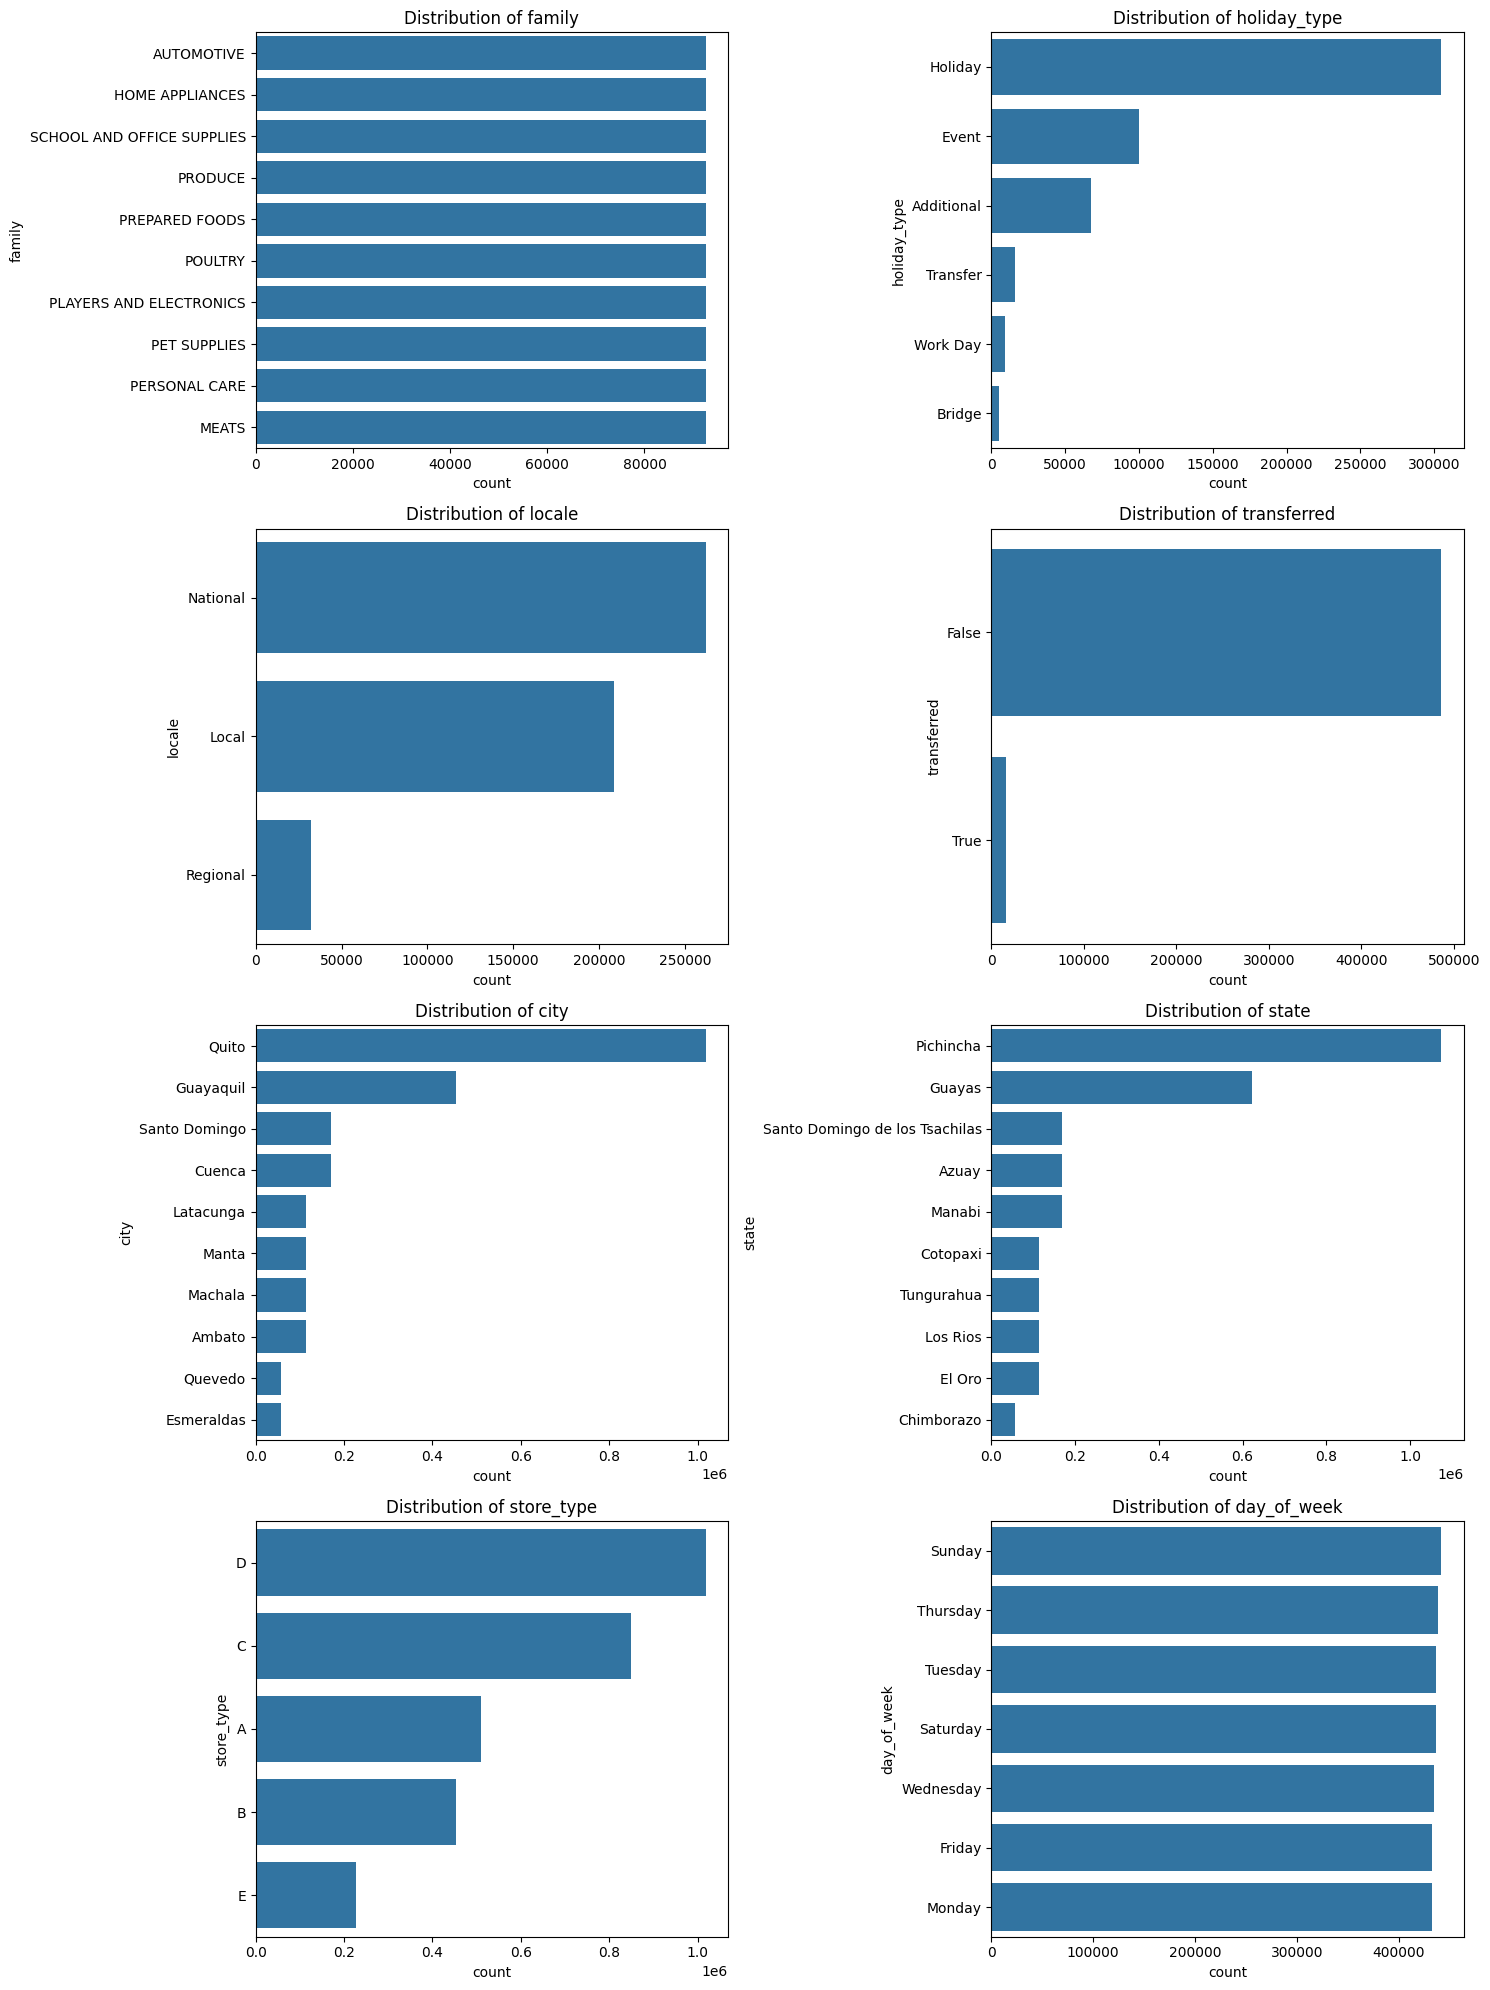

In [185]:
drop_cols = ['description', 'locale_name']  # Example: Too many unique values
cat_vars = train1.select_dtypes(include='object').columns.drop(drop_cols, errors='ignore')

# Plot categorical variables
plt.figure(figsize=(15, 20))
for i, col in enumerate(cat_vars, 1):
    plt.subplot(4, 2, i)
    sns.countplot(data=train1, y=col, order=train1[col].value_counts().index[:10])  # Top 10 categories
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()


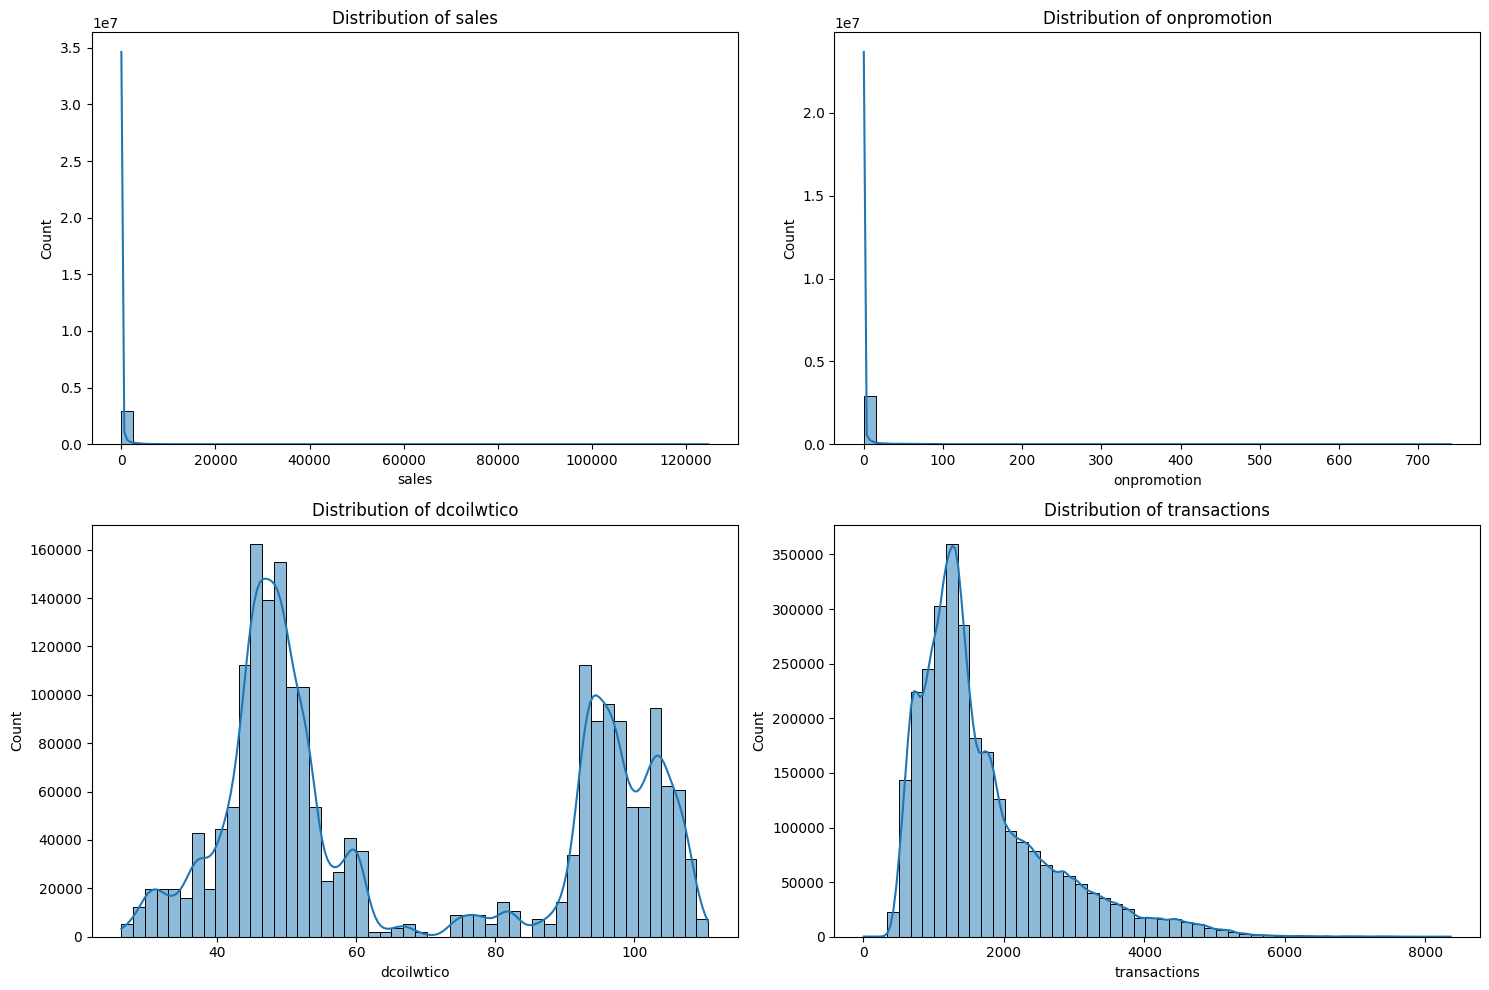

              sales   onpromotion    dcoilwtico  transactions
count  3.054348e+06  3.054348e+06  2.090286e+06  2.805231e+06
mean   3.590209e+02  2.617480e+00  6.807354e+01  1.697071e+03
std    1.107286e+03  1.225494e+01  2.569465e+01  9.668317e+02
min    0.000000e+00  0.000000e+00  2.619000e+01  5.000000e+00
25%    0.000000e+00  0.000000e+00  4.638000e+01  1.046000e+03
50%    1.100000e+01  0.000000e+00  5.346000e+01  1.395000e+03
75%    1.960110e+02  0.000000e+00  9.582000e+01  2.081000e+03
max    1.247170e+05  7.410000e+02  1.106200e+02  8.359000e+03


In [186]:
# Convert float16 to float32 to avoid NotImplementedError
train1['onpromotion'] = train1['onpromotion'].astype('float32')

# Define numerical variables
num_vars = ['sales', 'onpromotion', 'dcoilwtico', 'transactions']

# Plot distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_vars, 1):
    plt.subplot(2, 2, i)
    
    # Filter out NaN values for the current column
    plot_data = train1[col].dropna()
    
    # Use try-except to handle potential plotting issues
    try:
        sns.histplot(data=plot_data, kde=True, bins=50)
        plt.title(f'Distribution of {col}')
    except Exception as e:
        print(f"Could not plot {col}: {str(e)}")
        
plt.tight_layout()
plt.show()

# Summary statistics
print(train1[num_vars].describe())

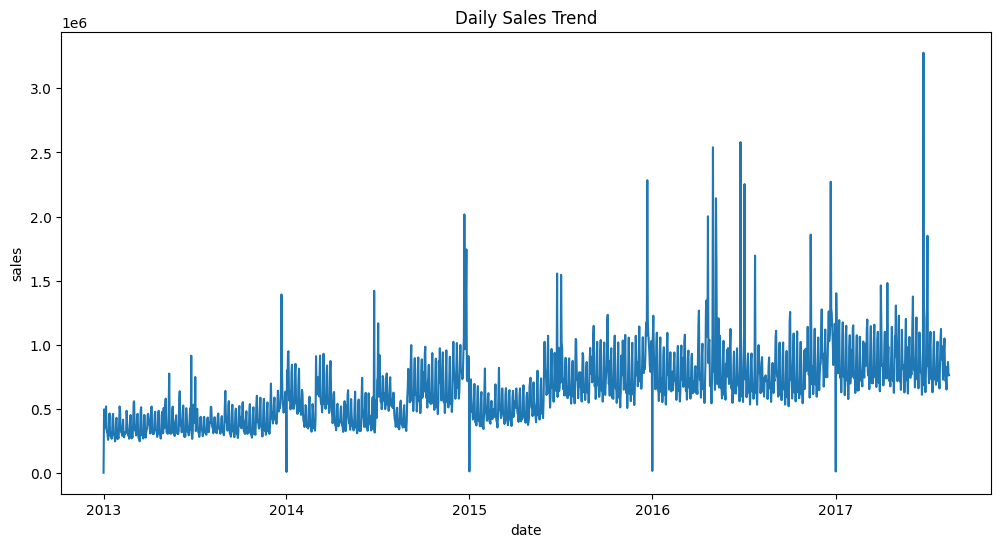

In [187]:
train1['day'] = train1['date'].dt.day
train1['day_name'] = train1['date'].dt.day_name()

# Plot sales over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=train1.groupby('date')['sales'].sum().reset_index(), x='date', y='sales')
plt.title('Daily Sales Trend')
plt.show()

In [188]:
#Basic Data Analysis

In [189]:
train1[["store_type", "sales"]].groupby(["store_type"], as_index=False).mean().sort_values(by="sales", ascending=False)

,store_type,sales
0,A,708.378174
3,D,352.084503
1,B,328.275238
4,E,270.285492
2,C,197.790649


In [190]:
train1[["family", "sales"]].groupby(["family"], as_index=False).mean().sort_values(by="sales", ascending=False).head(10)

,family,sales
12,GROCERY I,3790.432861
3,BEVERAGES,2394.912598
30,PRODUCE,1355.373657
7,CLEANING,1074.171509
8,DAIRY,711.175964
5,BREAD/BAKERY,464.150604
28,POULTRY,351.078796
24,MEATS,341.965912
25,PERSONAL CARE,271.192383
9,DELI,265.629730


In [191]:
train1[["holiday_type", "sales"]].groupby(["holiday_type"], as_index=False).mean().sort_values(by="sales", ascending=False)

,holiday_type,sales
0,Additional,487.628906
4,Transfer,467.753113
1,Bridge,446.750854
2,Event,425.660065
5,Work Day,372.157532
3,Holiday,358.433807


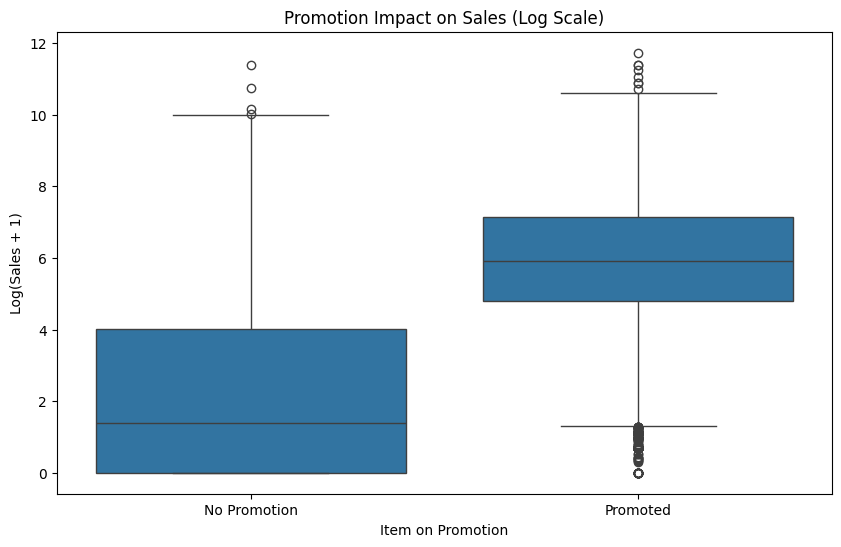

In [192]:
#Sales Distribution by promotion status

plt.figure(figsize=(10,6))
sns.boxplot(x=train1["onpromotion"] > 0, 
            y=np.log1p(train1["sales"]))  # Log transform for better visibility
plt.title("Promotion Impact on Sales (Log Scale)")
plt.xlabel("Item on Promotion")
plt.ylabel("Log(Sales + 1)")
plt.xticks([0,1], ["No Promotion", "Promoted"])
plt.show()

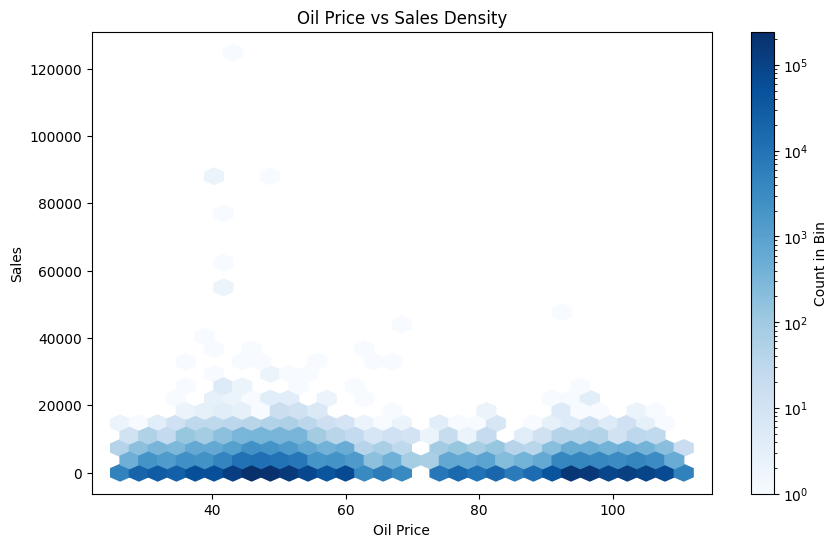

In [193]:
#Checking correlation between oil price and sales

plt.figure(figsize=(10,6))
plt.hexbin(x=train1["dcoilwtico"], y=train1["sales"], gridsize=30, cmap="Blues", bins='log')
plt.colorbar(label="Count in Bin")
plt.title("Oil Price vs Sales Density")
plt.xlabel("Oil Price")
plt.ylabel("Sales")
plt.show()

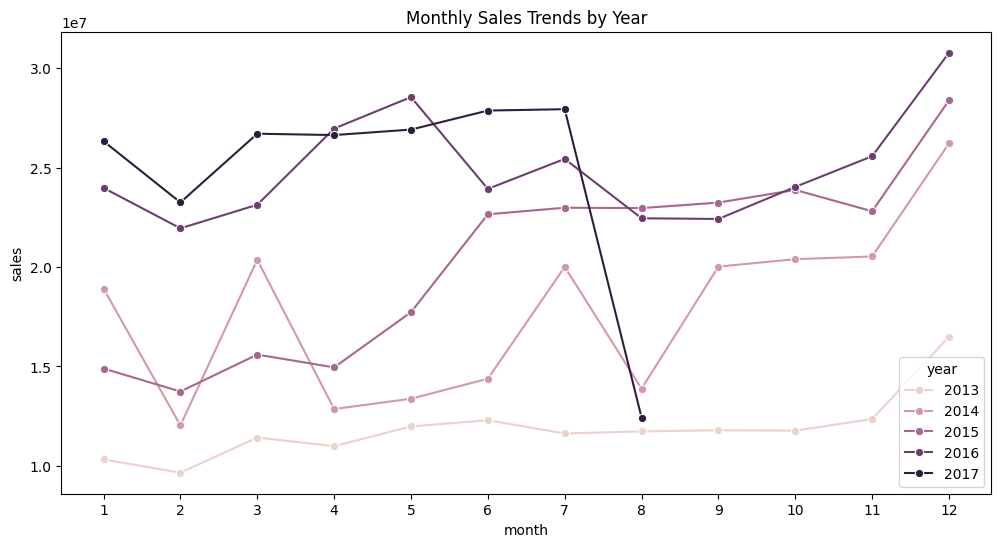

In [194]:
#Monthly sales Trend

monthly_sales = train1.groupby(["year", "month"])["sales"].sum().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(x="month", y="sales", hue="year", data=monthly_sales, marker="o")
plt.title("Monthly Sales Trends by Year")
plt.xticks(range(1,13))
plt.show()

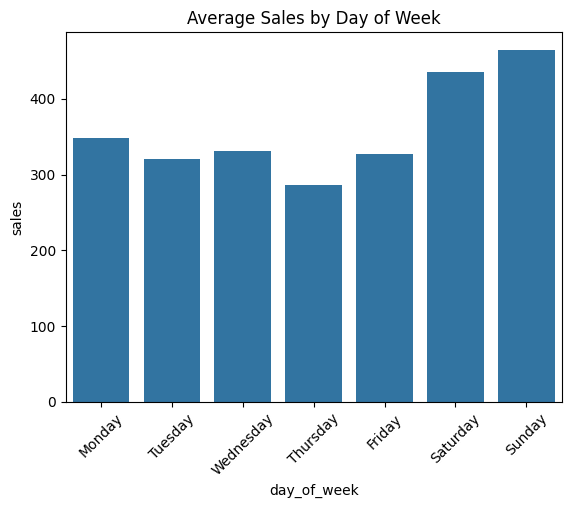

In [195]:
#Day of Week Analysis
dow_sales = train1.groupby("day_of_week")["sales"].mean().reset_index()
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.barplot(x="day_of_week", y="sales", data=dow_sales, order=order)
plt.title("Average Sales by Day of Week")
plt.xticks(rotation=45)
plt.show()

In [196]:
#Preprocessing the data 

In [197]:
#Outlier Detection

def business_aware_outliers(df, columns):
    """
    Detect outliers based on business rules for specified columns.
    
    Parameters:
        df (pd.DataFrame): Input dataframe
        columns (list): Columns to analyze (must include 'transactions' and 'dcoilwtico')
    
    Returns:
        pd.Index: Indices of outlier rows
    """
    outliers = pd.Series(False, index=df.index)
    
    # Column-specific rules
    for col in columns:
        if col == 'onpromotion':
            # Rule 1: Onpromotion (0-100 normal range)
            outliers |= df[col].gt(100)
            
        elif col == 'transactions':
            # Rule 2: Store-specific transaction limits (3σ)
            transaction_limits = df.groupby('store_nbr')[col].agg(['mean','std'])
            for store in transaction_limits.index:
                store_mask = (df['store_nbr'] == store)
                upper_limit = transaction_limits.loc[store, 'mean'] + 3*transaction_limits.loc[store, 'std']
                outliers |= store_mask & df[col].gt(upper_limit)
                
        elif col == 'dcoilwtico':
            # Rule 3: Oil price volatility (30-day rolling 3σ)
            oil_rolling = df[col].rolling(30).agg(['mean','std'])
            upper_oil = oil_rolling['mean'] + 3*oil_rolling['std']
            outliers |= df[col].gt(upper_oil.fillna(upper_oil.mean()))
    
    return outliers[outliers].index

# Usage
outlier_cols = ['onpromotion', 'dcoilwtico', 'transactions']
outliers = business_aware_outliers(train1, outlier_cols)
print(f"Business-validated outliers detected: {len(outliers)} ({len(outliers)/len(train1):.2%})")

Business-validated outliers detected: 46769 (1.53%)


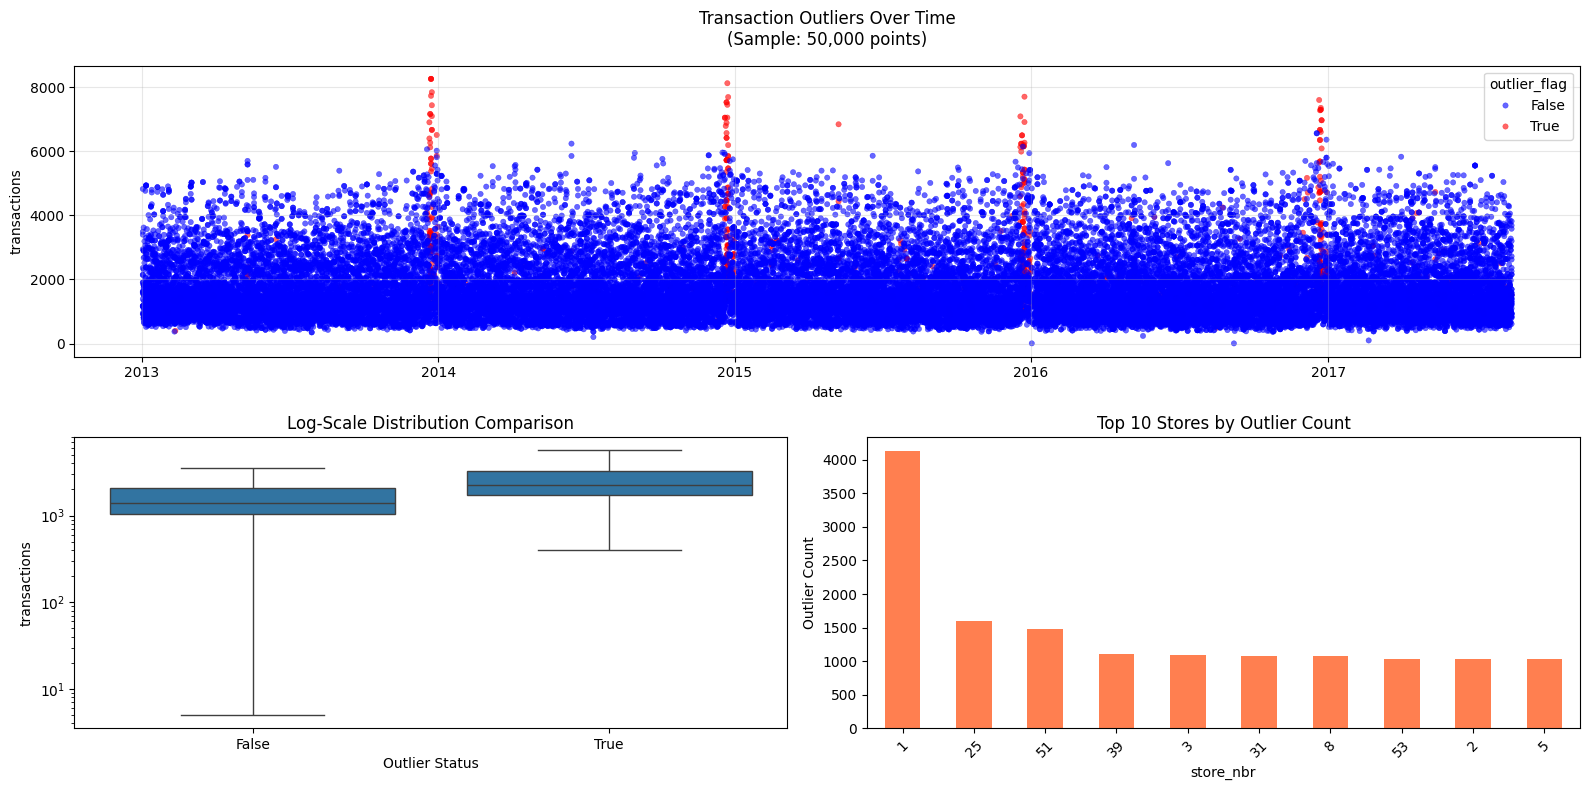

In [198]:
def plot_outliers_optimized(df, sample_size=50000):
    """
    Optimized visualization for large datasets with:
    - Smart sampling
    - Enhanced visual clarity
    - Faster rendering
    """
    
    # Make sure the DataFrame has the outlier_flag column
    if 'outlier_flag' not in df.columns:
        # Get the outlier indices from the business_aware_outliers function
        outlier_cols = ['onpromotion', 'dcoilwtico', 'transactions']
        outlier_indices = business_aware_outliers(df, outlier_cols)
        
        # Create the outlier_flag column
        df = df.copy()  # Create a copy to avoid modifying the original
        df['outlier_flag'] = False
        df.loc[outlier_indices, 'outlier_flag'] = True
    
    # 1. Smart Sampling - Stratified to preserve outlier ratio
    outlier_ratio = df['outlier_flag'].mean()
    sample_outliers = min(int(sample_size * outlier_ratio), 
                      df['outlier_flag'].sum())
    sample_normal = sample_size - sample_outliers
    
    outlier_sample = df[df['outlier_flag']].sample(sample_outliers, random_state=42)
    normal_sample = df[~df['outlier_flag']].sample(sample_normal, random_state=42)
    plot_sample = pd.concat([outlier_sample, normal_sample])
    
    # 2. Enhanced Visualization
    plt.figure(figsize=(16, 8))
    
    # Panel 1: Temporal View
    ax1 = plt.subplot(2, 2, (1, 2))
    sns.scatterplot(data=plot_sample, x='date', y='transactions',
                   hue='outlier_flag', palette={True: 'red', False: 'blue'},
                   alpha=0.6, s=15, edgecolor=None)
    plt.title(f"Transaction Outliers Over Time\n(Sample: {sample_size:,} points)", pad=15)
    plt.grid(True, alpha=0.3)
    
    # Panel 2: Distribution Comparison
    plt.subplot(2, 2, 3)
    sns.boxplot(x='outlier_flag', y='transactions', 
               data=plot_sample, showfliers=False)
    plt.yscale('log')
    plt.title("Log-Scale Distribution Comparison")
    plt.xlabel("Outlier Status")
    
    # Panel 3: Store-wise Outlier Count
    plt.subplot(2, 2, 4)
    store_outliers = df[df['outlier_flag']].groupby('store_nbr').size()
    store_outliers.nlargest(10).plot(kind='bar', color='coral')
    plt.title("Top 10 Stores by Outlier Count")
    plt.ylabel("Outlier Count")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_outliers_optimized(train1)

In [199]:
#Decision: Retain Outliers After careful analysis, we will preserve these identified outliers because they represent legitimate business scenarios, have statistical significance, provide value for robust modeling, and serve as natural indicators for exceptional events.

In [200]:
# Missing value summary
missing = train1.isnull().sum().sort_values(ascending=False)
missing_pct = (train1.isnull().mean()*100).sort_values(ascending=False)
pd.concat([missing, missing_pct], axis=1, keys=['Total', 'Percentage'])

,Total,Percentage
holiday_type,2551824,83.547258
locale,2551824,83.547258
locale_name,2551824,83.547258
description,2551824,83.547258
transferred,2551824,83.547258
dcoilwtico,964062,31.563594
transactions,249117,8.156143
id,0,0.000000
cluster,0,0.000000
day,0,0.000000
